In [1]:
import scipy
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.geodesic as geodesic
Geodesic = geodesic.Geodesic()
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings   
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 
#
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
m5 = xr.open_dataset('Meddy5.nc')
m5 = m5.swap_dims({'N_OBS':'dated'}).drop('N_OBS')
#Let's oversample a bit to try detect loops more precisely
m5 = m5.interp(dated=np.arange(m5.dated.min().values,m5.dated.max().values,dtype='datetime64[h]'))
m5 = m5.isel(dated=slice(1,-1,4))
m5

<xarray.Dataset> Size: 207kB
Dimensions:  (dated: 3232)
Coordinates:
  * dated    (dated) datetime64[ns] 26kB 1994-01-08T16:00:00 ... 1995-07-01T0...
Data variables:
    dtnum    (dated) float64 26kB 7.283e+05 7.283e+05 ... 7.288e+05 7.288e+05
    lat      (dated) float64 26kB 38.4 38.38 38.37 38.33 ... 30.93 30.94 30.94
    lon      (dated) float64 26kB -10.02 -9.983 -9.951 ... -15.79 -15.79 -15.8
    p        (dated) float64 26kB 929.4 929.0 928.6 928.3 ... 959.7 960.3 960.9
    t        (dated) float64 26kB 12.34 12.33 12.33 12.33 ... 9.49 9.48 9.475
    u        (dated) float64 26kB 0.1968 0.134 0.07116 ... -0.04802 -0.05547
    v        (dated) float64 26kB -0.1351 -0.1698 -0.2046 ... 0.0251 0.01834

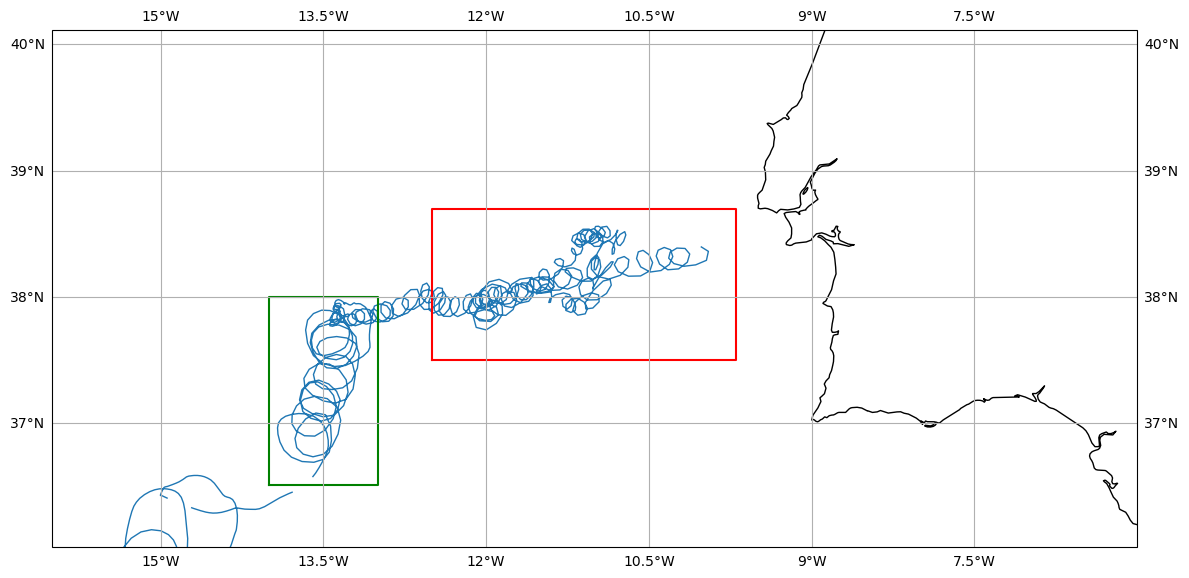

In [50]:
f=plt.figure(figsize=(14,8))
ax=f.add_subplot(111,projection=ccrs.Miller())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.plot(m5['lon'],m5['lat'],'-',linewidth=1,transform=ccrs.PlateCarree())

ax.plot([-12.5,-9.7,-9.7,-12.5,-12.5],[37.5,37.5,38.7,38.7,37.5],'r-',transform=ccrs.PlateCarree())
ax.plot([-14,-13,-13,-14,-14],[36.5,36.5,38,38,36.5],'g-',transform=ccrs.PlateCarree())

ax.set_extent([-16,-6,36,40])

## Loops detection

In [3]:
az=np.zeros([len(m5.dated),len(m5.dated)])*np.nan
for i in np.arange(0,len(m5.dated)):
    #Entre 5 et 50 points 
    for j in np.arange(i+5,min(i+50,len(m5.dated))):
        a=Geodesic.inverse((m5.lon.isel(dated=i),m5.lat.isel(dated=i)),(m5.lon.isel(dated=j),m5.lat.isel(dated=j)))
        az[i,j]=a[0][0]

In [4]:
small_dist=np.argwhere(az<2500)
loops=small_dist[0,:]
last_loop=small_dist[0,:]
for i in np.arange(1,len(small_dist)):
    if small_dist[i,0]<last_loop[1]:
        pass
    else:
        loops=np.vstack([loops,small_dist[i,:]])
        last_loop=small_dist[i,:]

# Small Meddy

Text(0.5, 1.0, '1994-01-08 -->  1994-04-08 : 27 loops')

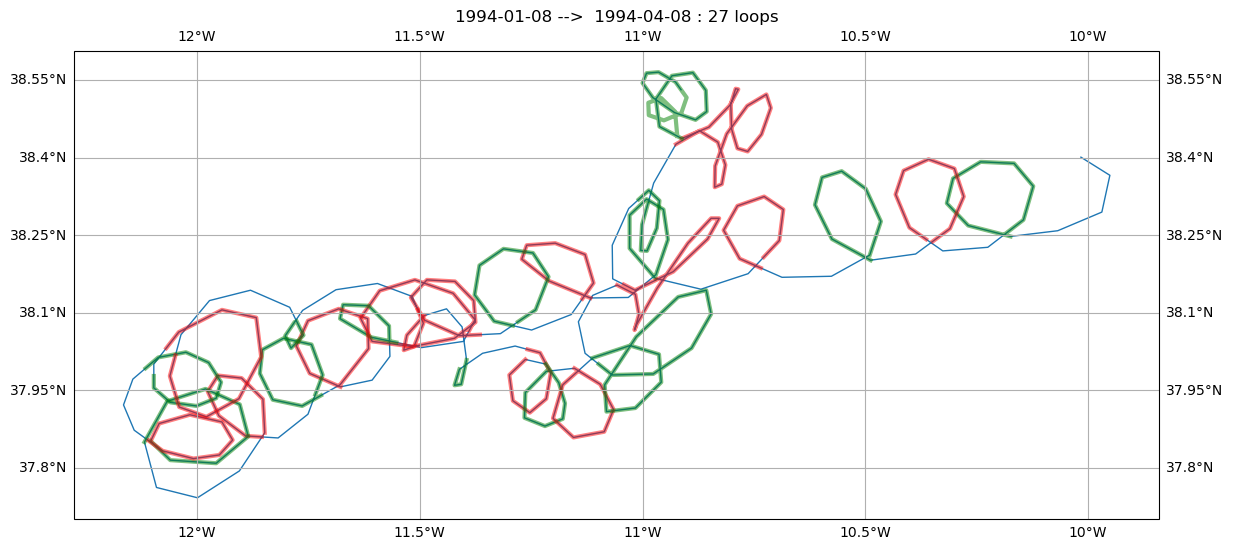

In [5]:
f=plt.figure(figsize=(14,8))
ax=f.add_subplot(111,projection=ccrs.Miller())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.plot(m5['lon'][:540],m5['lat'][:540],'-',linewidth=1,transform=ccrs.PlateCarree())

c=['g','r']
i=0
for l in loops[:27]:
    ax.plot(m5['lon'][l[0]:l[1]+1],m5['lat'][l[0]:l[1]+1],'-',color=c[i%2],linewidth=3,alpha=.5,transform=ccrs.PlateCarree())
    i+=1

ax.set_title(str(m5.dated[0].values)[0:10]+' -->  '+str(m5.dated[540].values)[0:10]+' : 27 loops')    

Text(0.5, 1.0, 'mean velocity = 0.19 m.s-1')

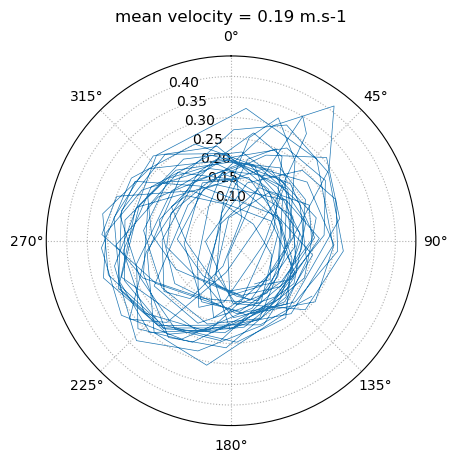

In [38]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
lm5 = m5.isel(dated=slice(0,540))
theta=np.arctan2(lm5['u'],lm5['v'])
r=np.sqrt(lm5['u']**2+lm5['v']**2)
ax.plot(theta, r,'-',linewidth=.5)
ax.set_rmax(0.45)
ax.set_rticks([0.1,.15, .2,.25,.3,.35,.4])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True,linestyle=':')
ax.set_title('mean velocity = '+str(r.mean().values)[:4]+' m.s-1')

In [40]:
# Taille des tourbillons
diamz=np.zeros(27)
i=0
for l in loops[:27]:
    lm5 = m5.isel(dated=slice(l[0],l[1]))
    rlat = [radians(la) for la in lm5['lat'].values]
    rlon = [radians(lo) for lo in lm5['lon'].values]
    result = haversine_distances(np.stack([rlat,rlon]).transpose())
    result = result * 6371000/1000  # multiply by Earth radius to get kilometers
    diamz[i]=result.max()
    i+=1
diamz    

array([17.31566312, 17.18631535, 20.17531197, 15.35886737, 17.10224704,
       16.87806976, 16.61423909, 23.72750386, 13.23978176, 16.79408843,
       15.15457525, 15.80335129, 20.4928047 , 16.15638739, 15.318788  ,
       24.49102376,  5.88479819,  9.10103274,  5.94021552, 13.62842847,
       13.34454379, 14.90115278, 32.67687212, 29.20122321, 13.01449088,
       22.32164197, 15.60633969])

## Bigger Meddy (or meddies combined to form a bigger one)

Text(0.5, 1.0, '1994-08-08 -->  1994-10-02')

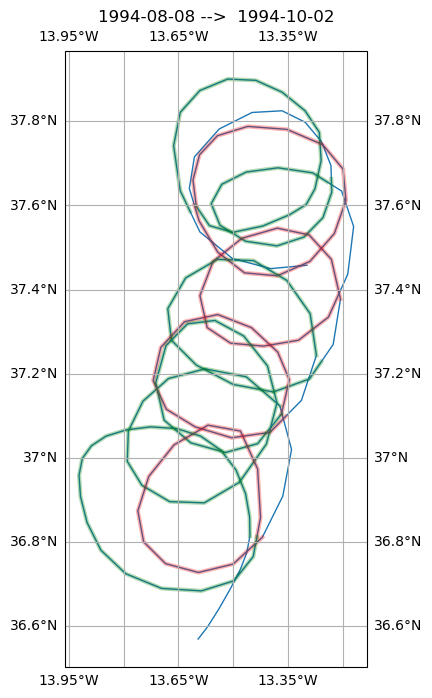

In [51]:
f=plt.figure(figsize=(14,8))
ax=f.add_subplot(111,projection=ccrs.Miller())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.plot(m5['lon'][1270:1600],m5['lat'][1270:1600],'-',linewidth=1,transform=ccrs.PlateCarree())

c=['g','r']
i=0
for l in loops[66:75]:
    ax.plot(m5['lon'][l[0]:l[1]+1],m5['lat'][l[0]:l[1]+1],'-',color=c[i%2],linewidth=3,alpha=.3,transform=ccrs.PlateCarree())
    i+=1

ax.set_title(str(m5.dated[1270].values)[:10]+' -->  '+str(m5.dated[1600].values)[:10])    

Text(0.5, 1.0, 'mean velocity = 0.28 m.s-1')

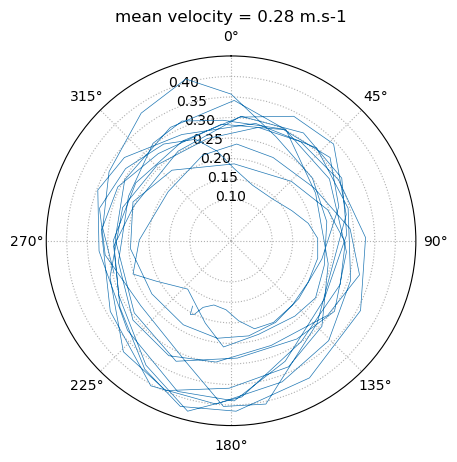

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
lm5 = m5.isel(dated=slice(1270,1600))
theta=np.arctan2(lm5['u'],lm5['v'])
r=np.sqrt(lm5['u']**2+lm5['v']**2)
ax.plot(theta, r,'-',linewidth=.5)
ax.set_rmax(0.45)
ax.set_rticks([0.1,.15, .2,.25,.3,.35,.4])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True,linestyle=':')
ax.set_title('mean velocity = '+str(r.mean().values)[:4]+' m.s-1')

In [52]:
# Meddy sizes
diamz=np.zeros(9)
i=0
for l in loops[66:75]:
    lm5 = m5.isel(dated=slice(l[0],l[1]))
    rlat = [radians(la) for la in lm5['lat'].values]
    rlon = [radians(lo) for lo in lm5['lon'].values]
    result = haversine_distances(np.stack([rlat,rlon]).transpose())
    result = result * 6371000/1000  # multiply by Earth radius to get kilometers
    diamz[i]=result.max()
    i+=1

In [53]:
diamz

array([40.41191963, 40.0044277 , 29.69274673, 35.02478585, 40.13869596,
       35.84483733, 49.17018963, 39.58389158, 49.85601732])

Text(1575, 1717.9101895855758, '1717')

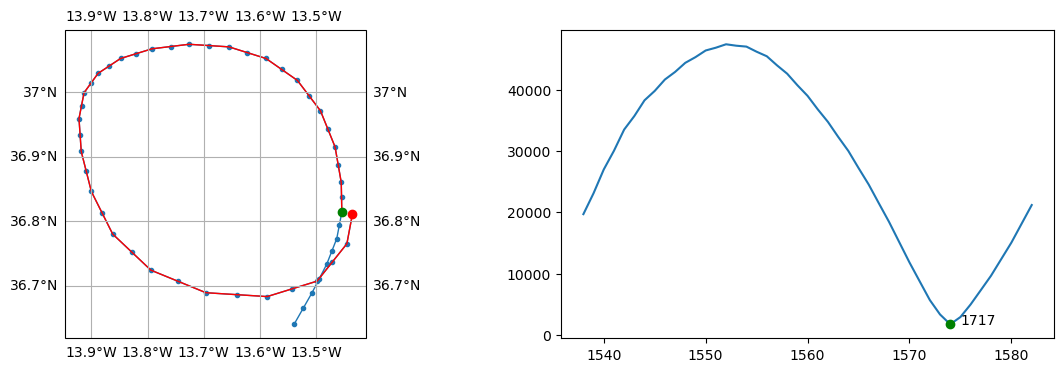

In [37]:
i=loops[74][0]
j=loops[74][1]

f=plt.figure(figsize=(14,4))
ax=f.add_subplot(121,projection=ccrs.Miller())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.plot(m5['lon'][i],m5['lat'][i],'ro',transform=ccrs.PlateCarree(),zorder=3)
ax.plot(m5['lon'][i:i+50],m5['lat'][i:i+50],'.-',linewidth=1,transform=ccrs.PlateCarree())
ax.plot(m5['lon'][i:j+1],m5['lat'][i:j+1],'r-',linewidth=1,transform=ccrs.PlateCarree())

mind=np.nanargmin(az[i,:])
ax.plot(m5['lon'][mind],m5['lat'][mind],'go',transform=ccrs.PlateCarree(),zorder=3)

ax1=f.add_subplot(122)
ax1.plot(az[i,:])
ax1.plot(mind,az[i,mind],'go')
ax1.text(mind+1,az[i,mind],s=str(int(az[i,mind])))

Text(1323, 760.0560443778517, '760')

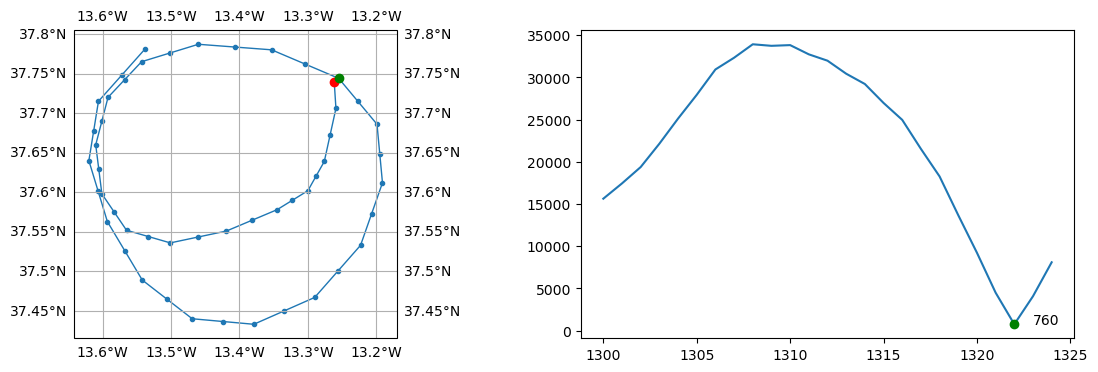

In [82]:
i=1295

f=plt.figure(figsize=(14,4))
ax=f.add_subplot(121,projection=ccrs.Miller())
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.plot(m5['lon'][i],m5['lat'][i],'ro',transform=ccrs.PlateCarree(),zorder=3)
ax.plot(m5['lon'][i:i+50],m5['lat'][i:i+50],'.-',linewidth=1,transform=ccrs.PlateCarree())

mind=np.nanargmin(az[i,:])
ax.plot(m5['lon'][mind],m5['lat'][mind],'go',transform=ccrs.PlateCarree(),zorder=3)

ax1=f.add_subplot(122)
ax1.plot(az[i,:])
ax1.plot(mind,az[i,mind],'go')
ax1.text(mind+1,az[i,mind],s=str(int(az[i,mind])))